<h1 style="text-align:center">LQR Control of a Simple Mass-Spring-Damper <br> System with a Disturbance Force</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/   </p>

<p style="text-align:center">
	<img src="http://shared.crawlab.org/MassSpringDamper_SeismicWithDisturbance_Horiz.png" alt="A Mass-Spring-Damper System with a Disturbance Force" width=50%/></a><br>
    <strong> Figure 1: A Mass-Spring-Damper System with a Disturbance Force</strong>
</p>

This notebook simluates a the simple mass-spring-damper model like the one shown in Figure 1. The system has both a position input $y(t)$ and a force input, $f(t)$. This system could also be used to model the position control of a mass via a Proportional Derivative (PD) controller.

The equationof motion for this system is:

$ \quad m\ddot{x} + c \dot{x} + k x = c \dot{y} + k y - f $

We can also rewrie this in terms of damping ratio, $\zeta$, and natural frequency, $\omega_n$:

$ \quad \ddot{x} + 2 \zeta \omega_n \dot{x} + \omega_n^2 x = \zeta \omega_n \dot{y} + \omega_n^2 y - \frac{f}{m} $

However, as we'll see below, we often will collect terms so that our ''motion'' variable are all on the left-hand side, like:

$ \quad \ddot{x} = \frac{k}{m}\left( y - x \right) + \frac{c}{m} \left(\dot{y} - \dot{x} \right) - \frac{f}{m} $


In [1]:
import numpy as np

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# Import the ODE solver
from scipy.integrate import odeint

## Functions defining the equations of motion and inputs
We will first define the functions that define the equations of motion and the inputs. One "trick" that we will use is to define $y(t)$ and $\dot{y}(t)$ as states. This allows us to specifiy an acceleration input $\ddot{y}(t)$, which gets propogated to the $y(t)$ and $\dot{y}(t)$ via the equations of motion (or state-transition matrix if we were solving in "true" matrix-based state-space form).

So, we can then define our states as vector $ \bar{w} = \left[x \ \dot{x} \  y \ \dot{y}\right]^T $ and the inputs as $\bar{u} = \left[\ddot{y} \ f \right]$.

Then the system of first-order ODEs we have to solve is:

$ \quad \dot{\bar{w}} = g(\bar{w}, \bar{u}, t) $

Writing these out, we have:

$ \quad \dot{\bar{w}}  = \left[\dot{x} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \frac{k}{m}(y - x) + \frac{c}{m}\left(\dot{y} - \dot{x}\right) - \frac{f}{m} $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \dot{y}$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \left.\ddot{y}\right]$

Notice that the $\ddot{y}$ in the last line is what we get to specify to generate the position input. In addition to allowing us to only specify one input that gets propograted to y and $\dot{y}$, describing inputs in the acceleration domain is often preferrable. This is because representing a realistic input in this domain is often easier than in the position or velocity domain.

In [4]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    x, x_dot, y, y_dot = w
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p

    # Create sysODE = (x', x_dot', y', y_dot')
    sysODE = [x_dot,
             k/m * (y - x) + c/m * (y_dot - x_dot) - f(t, p)/m,
             y_dot,
             y_ddot(t, p)]
    return sysODE


def f(t, p):
    """
    defines the disturbance force input to the system
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # Select one of the two inputs below
    # Be sure to comment out the one you're not using
    
    # Input Option 1: 
    #    Just a step in force beginning at t=DistStart
    # f = F_amp * (t >= DistStart)
    
    # Input Option 2:
    #    A pulse in force beginning at t=DistStart and ending at t=(DistStart+0.1)
    f = F_amp * (t >= DistStart) * (t <= DistStart + 0.1)
    
    return f


def y_ddot(t, p):
    """
    Defines the accel input to the system.
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    """
    m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp = p
    
    # These are the times for a bang-coast-bang input 
    t1 = StartTime
    t2 = (Vmax/Amax) + t1
    t3 = (Distance/Vmax) + t1
    t4 = (t2 + t3) - t1
    
    if t3 <= t2: # command should be bang-bang, not bang-coast-bang
        t2 = np.sqrt(Distance/Amax)+t1
        t3 = 2*np.sqrt(Distance/Amax)+t1
        
        accel = Amax*(t > t1) - 2*Amax*(t > t2) + Amax*(t > t3)
    
    else: # command is bang-coast-bang
        accel = Amax*(t > t1) - Amax*(t > t2) - Amax*(t > t3) + Amax*(t > t4)

    return accel

In [5]:
# Define the parameters for simluation
m = 1.0                      # mass (kg)
k = (1.0*2*np.pi)**2             # spring constant (N/m)

wn = np.sqrt(k/m)            # natural frequency (rad/s)

# Select damping ratio and use it to choose an appropriate c
zeta = 0.05                   # damping ratio
c = 2*zeta*wn*m              # damping coeff.

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 10.0
numpoints = 10001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0,stoptime,numpoints)

# Initial conditions
x_init = 0.0                        # initial position
x_dot_init = 0.0                    # initial velocity
y_init = 0.0
y_dot_init = 0.0

# Set up the parameters for the input function
Distance = 1.0               # Desired move distance (m)
Amax = 20.0                   # acceleration limit (m/s^2)
Vmax = 2.0                   # velocity limit (m/s)
StartTime = 0.5              # Time the y(t) input will begin
DistStart = 4.5              # Time the disturbance input will begin
F_amp = 100.0                 # Amplitude of Disturbance force (N)

# Pack the parameters and initial conditions into arrays 
p = [m, k, c, Distance, StartTime, Amax, Vmax, DistStart, F_amp]
x0 = [x_init, x_dot_init, y_init, y_dot_init]

In [6]:
# Call the ODE solver.
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

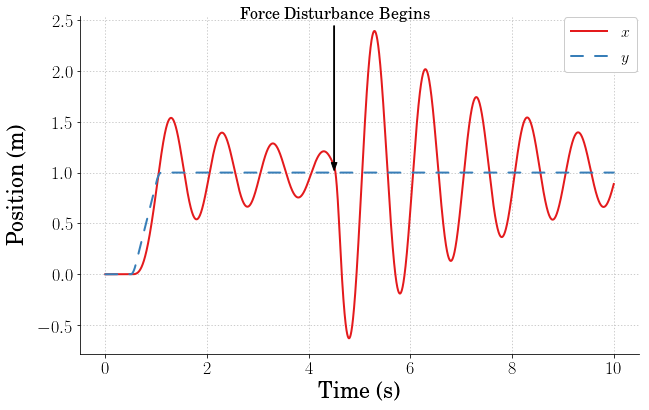

In [7]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)
# plt.ylim(-1.,1.)

# plot the response
plt.plot(t,resp[:,0], linewidth=2, linestyle = '-', label=r'$x$')
plt.plot(t,resp[:,2], linewidth=2, linestyle = '--', label=r'$y$')

# If there is a non-zero force disturbance show where it began via an annotation
if F_amp > 0:
    plt.annotate(r'Force Disturbance Begins',
         xy=(DistStart,resp[-1,2]), xycoords='data',
         ha='center',
         xytext=(DistStart, 1.05*np.max(resp[:,0])), textcoords='data', fontsize=16,
         arrowprops=dict(arrowstyle="simple, head_width = 0.35, tail_width=0.05", connectionstyle="arc3", color="black"),color = "black")
    

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Disturbance_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

## Forces
We can also easily take a look at the forces acting on the system.

The forces resulting from the position input are just the force from the spring, $F_{sp}$, and the force from damper, $F_{d}$:

$ \quad F_{pos} = F_{sp} + F_{d} = k \left(y - x\right) + c \left(\dot{y} - \dot{x}\right) $

In [8]:
Fsp = k * (resp[:,2] - resp[:,0])       # Spring Force (N)
Fd =  c * (resp[:,3] - resp[:,1])       # Damping Force (N)

F_pos = Fsp + Fd

# Calculate the disturbance force over time by calling the disturbance force function
F_dist = np.zeros_like(t)

for ii in range(len(t)):
    F_dist[ii] = -f(t[ii],p)

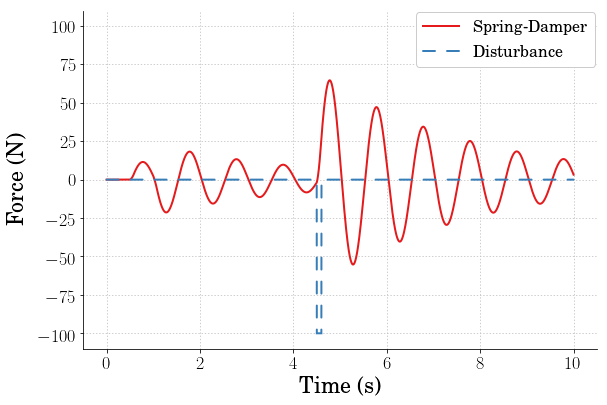

In [9]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Force (N)',family='serif',fontsize=22,weight='bold',labelpad=10)

# You may need to reset these limits based on the forces in your simulation
ymax = 1.1 * np.max([np.max(np.abs(F_pos)), np.max(np.abs(F_dist))])
plt.ylim(-ymax, ymax)

# plot the response
plt.plot(t,F_pos, linewidth=2, linestyle = '-', label=r'Spring-Damper')
plt.plot(t,F_dist, linewidth=2, linestyle = '--', label=r'Disturbance')

leg = plt.legend(loc='best', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Disturbance_Forces.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

## Simulation with the Control System Library
We can also simulate this system using the [Python Control System Library](https://python-control.readthedocs.io/en/latest/). We'll first set up the state-space form of the equations of motion by writing our system of first-order ODEs in matrix form. Our system of first-order ODEs is:

$ \quad \dot{\bar{w}} = g(\bar{w}, \bar{u}, t) $

Expanding these, we have:

$ \quad \dot{\bar{w}}  = \left[\dot{x} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \frac{k}{m}(y - x) + \frac{c}{m}\left(\dot{y} - \dot{x}\right) - \frac{f}{m} $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \dot{y}$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \left.\ddot{y}\right]$

We want to put this into the "normal" state-space form:

$ \quad \dot{\bar{w}} = A \bar{w} + B \bar{u} $

where A and B are matrices, 

$ \quad \bar{u} = \begin{bmatrix} \ddot{y} \\ f \end{bmatrix} $

and, as before, the state vector, $\bar{w}$, is:

$ \quad \bar{w} = \begin{bmatrix} \dot{x} \\ \ddot{x} \\ \dot{y} \\ \ddot{y} \end{bmatrix} $

***Note:*** It is more common to see the state vector written as $\bar{x}$ instead of $\bar{w}$ as we've written here.

Looking at our equations of motion, we can then write:

$ \quad \dot{\bar{w}} = \begin{bmatrix} 0    &    1 & 0   & 0   \\ 
                                        -k/m & -c/m & k/m & c/m \\
                                        0    &    0 & 0   & 1   \\
                                        0    &    0 & 0   & 0   \end{bmatrix} \bar{w} 
                        + \begin{bmatrix} 0 & 0    \\
                                          0 & -1/m \\
                                          0 & 0    \\
                                          1 & 0    \end{bmatrix} \bar{u}  $
                                          
where:

$ \quad A = \begin{bmatrix} 0    &    1 & 0   & 0   \\ 
                            -k/m & -c/m & k/m & c/m \\
                            0    &    0 & 0   & 1   \\
                            0    &    0 & 0   & 0   \end{bmatrix} $

and:

$ \quad B = \begin{bmatrix} 0 & 0    \\
                            0 & -1/m \\
                            0 & 0    \\
                            1 & 0    \end{bmatrix} $

Now that we've determined what the state-space matrices are, we can set up the system using the Control Systems Library. To do so, we'll first need to import the library:

In [10]:
import control

Then, we'll first define the matrices. In this case, we'll set the output matrix, C, to be diagonal, which will output each state independently.

In [11]:
A = np.array([[0, 1, 0, 0],
              [-k/m, -c/m, k/m, c/m],
              [0, 0, 0, 1],
              [0, 0, 0, 0]])

B = np.array([[0, 0],
              [0, -1/m],
              [0, 0],
              [1, 0]])

C = np.eye(4,4) # creates a 4x4 identity matrix

D = np.zeros((4,2)) # no direct passthrough of input to output

Now, we can use the `control.ss` method to create the system.

In [12]:
sys = control.ss(A, B, C, D)

As we saw above, the `odeint` method of simluating the system needed all of the input to be defined in function form. However, the Control System Library needs the inputs to be arrays. So, we need to generate the arrays for our inputs, $\ddot{y}$ and $f(t)$.

In this case, since we already have the funcitonal form define, we can use those funcitons to fill the needed arrays.

In [13]:
yddot_input = y_ddot(t, p)
force_input = f(t, p)

In [14]:
t_resp, resp_out, states_out = control.forced_response(sys, t, [yddot_input, force_input])

Now, let's plot this response as we did for the `odeint` simulated version above.

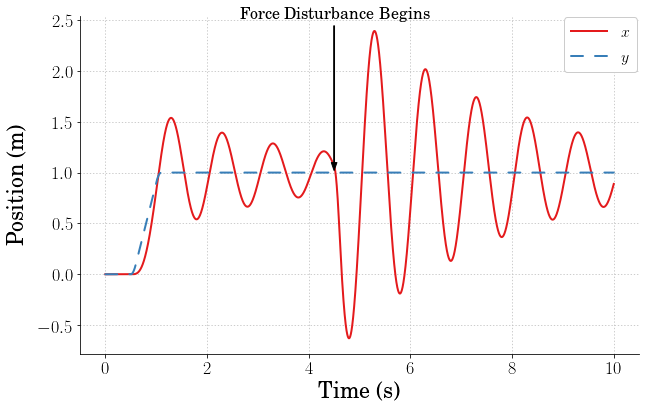

In [15]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)
# plt.ylim(-1.,1.)

# plot the response
plt.plot(t, resp_out[0,:], linewidth=2, linestyle = '-', label=r'$x$')
plt.plot(t, resp_out[2,:], linewidth=2, linestyle = '--', label=r'$y$')

# If there is a non-zero force disturbance show where it began via an annotation
if F_amp > 0:
    plt.annotate(r'Force Disturbance Begins',
         xy=(DistStart,resp[-1,2]), xycoords='data',
         ha='center',
         xytext=(DistStart, 1.05*np.max(resp_out[0,:])), textcoords='data', fontsize=16,
         arrowprops=dict(arrowstyle="simple, head_width = 0.35, tail_width=0.05", connectionstyle="arc3", color="black"),color = "black")
    

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Disturbance_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

The plot matches the one above, as it should.

## LQR Control

The Control System Library also has several control design tools built in (as you might expect it to). Here, we'll design a [Linear Quadratic Regulator (LQR)](https://en.wikipedia.org/wiki/Linear–quadratic_regulator) for this system.

The form of the contorl law for LQR is:

$ \quad \bar{u} = K \bar{w} $

where $K$ is a matrix containing gains. The gains multiple each state of the system via the state vector $\bar{w}$. Hence, this is a *full-state* feedback controller. 

The full derivation of the controller is beyond the scope of this notebook, but we do need to know that it is an (mathmeatically, not necessarily-practically) optimal controller. It is desined by picking the gain matrix to minimize a cost function of the form:

$ \quad J = \int_0^\infty \bar{w}^T Q\bar{w} + \bar{u}^T R \bar{u} + 2\bar{w}^T N \bar{u}\; dt $

For our purposes, let's ignore the $N$ matrix for now and concentrate on the $Q$ and $R$ matrices. These two matrices must be positive-semidefinite. The $Q$ matrix effectively penalizes states from deviating from the desired, regulated value. The $R$ matrix penalizes actuator effort. So, by changing the relative values within $Q$ we can value one state over another and by changing the ratio of values between $Q$ and $R$, we can balance performance and actuator effort.

As a simple choice, here let's set $Q$ to penalize $x$ and $\dot{x}$ equally. We won't penalize the position input $y$ or its deriviative.

In [16]:
Q = np.array([[ 1000,  0,  0,  0],
              [ 0,  1,  0,  0],
              [ 0,  0,  0,  0],
              [ 0,  0,  0,  0]])

For this problem, we'll also need to slightly redefine our $B$ matrix to only include the input that we can control $\ddot{y}$. It becomes:

$ \quad \widehat{B} = \begin{bmatrix} 0  \\
                            0  \\
                            0  \\
                            1  \end{bmatrix} $

We'll set R to something small, since we don't want or need to penalize the acceleration input to heavily. Since the revised $B$ matrix, $\widehat{B}$ is just a column, the $R$ matrix becomes a scalar.

In [17]:
B_hat = np.array([[0], [0], [0], [1]])

R = 0.001

Now, we can use the `control.lqr` method of the Control System Library to design the controller by simply passing it the system, $Q$, and $R$ matrices. 

In [18]:
K, _, closedLoopEigenvalues = control.lqr(A, B_hat, Q, R)

Now, we need to use the calculated gain matrix to implement the controller. To do so, we'll write:

$ \quad \widehat{A} = A - \widehat{B}K $

$ \quad \dot{\bar{w}} = \widehat{A} \bar{w} + B_{dist} f $

where $B_{dist}$ is just the part of the original matrix that operates on the disturbance force, $f$:

$ \quad B_{dist} = \begin{bmatrix}  0    \\
                                    -1/m \\
                                    0    \\
                                    0    \end{bmatrix} $

In [19]:
A_hat = A - B_hat * K

B_dist = np.array([[0], [-1/m], [0], [0]])

# C is unchanged

D_hat = D = np.zeros((4,1)) # no direct passthrough of input to output

In [20]:
sys_lqr = control.ss(A_hat, B_dist, C, D_hat)

In this formulation, we are just looking at the disturbance rejection properties of this controller. 

*Note:* This notebook will be updated soon to include position response, as well.

In [21]:
t_LQRresp, LQRresp_out, LQRstates_out = control.forced_response(sys_lqr, t, force_input)

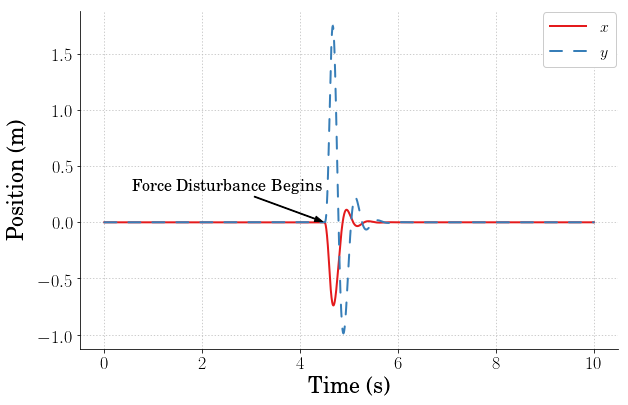

In [22]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)
# plt.ylim(-1.,1.)

# plot the response
plt.plot(t, LQRresp_out[0,:], linewidth=2, linestyle = '-', label=r'$x$')
plt.plot(t, LQRresp_out[2,:], linewidth=2, linestyle = '--', label=r'$y$')

# If there is a non-zero force disturbance show where it began via an annotation
if F_amp > 0:
    plt.annotate(r'Force Disturbance Begins',
         xy=(DistStart,LQRresp_out[-1,2]), xycoords='data',
         ha='center',
         xytext=(DistStart-2, 2.5*np.max(LQRresp_out[0,:])), textcoords='data', fontsize=16,
         arrowprops=dict(arrowstyle="simple, head_width = 0.35, tail_width=0.05", connectionstyle="arc3", color="black"),color = "black")
    

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Disturbance_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

To form some intuition about the LQR controller behavior, try changing the values in the $Q$ and $R$ matrices and re-running the code. For example, if you place higher weights on the 2nd state, which represents the velocity of the mass $\dot{x}$, you should see a response that exhibits a higher damping ratio than for lower weights on the state. You can also add weights to the $y$ and $\dot{y}$ states to limit its motion.

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD-style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [23]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))